In [335]:
import numpy as np
import pandas as pd

## 数据预处理
读取上位机保存的数据，记录加速度、角速度和角度

In [336]:
usecols = ['ax(g)', 'ay(g)', 'az(g)', 'wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)', 'AngleX(deg)',
           'AngleY(deg)', 'AngleZ(deg)']
data_base = pd.read_csv('../data/201217142813.txt', usecols=usecols ,sep=r'\s+')
acc_base = data_base.loc[:, ['ax(g)', 'ay(g)', 'az(g)']].values
omega_base = data_base.loc[:, ['wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)']].values
angle_base = data_base.loc[:, ['AngleX(deg)', 'AngleY(deg)', 'AngleZ(deg)']].values

读取上位机传上来的原始数据，按照16进制来发送，一帧包含三个数据包：
* 包头55 51: 加速度数据包
* 55 52: 角速度数据包
* 55 53: 角度数据包

In [337]:
# import re
# with open('../data/original_data.txt', 'r') as fr:
#     line = fr.readline()
#     data_group = re.split('55 51|55 52|55 53', line)

解析数据包，逐包解析。

加速度、角速度和角度的数据都是拆分成高低位的，组合起来形成一个 `short` 类型的量。
Python 处理十六进制的数据比较麻烦，从字符变量转换到十六进制数据也不方便，这里是将十六进制数据转换成十进制数据来处理，同时利用 `np.int16` 类型来替代 `short` 类型以便于显示负数。


In [338]:
# acc_orig = np.zeros([int((len(data_group)-1)/3), 3], dtype=np.float32)
# omega_orig = np.zeros([int((len(data_group)-1)/3), 3], dtype=np.float32)
# angle_orig = np.zeros([int((len(data_group)-1)/3), 3], dtype=np.float32)
# acc_orig = []
# omega_orig = []
# angle_orig = []
# rounds = 0
# for index in range(1, len(data_group)):
#     data = data_group[index].split(' ')[1:-4]
#     if index == 1 + 3*rounds:
#         acc_x = np.int16(int(data[0], 16) + np.int16(int(data[1], 16) * 256)) / 32768 * 16
#         acc_y = np.int16(int(data[2], 16) + np.int16(int(data[3], 16) * 256)) / 32768 * 16
#         acc_z = np.int16(int(data[4], 16) + np.int16(int(data[5], 16) * 256)) / 32768 * 16
#         acc_orig.append([acc_x, acc_y, acc_z])
#     elif index == 2 + 3*rounds:
#         omega_x = np.int16(int(data[0], 16) + np.int16(int(data[1], 16) * 256)) / 32768 * 2000
#         omega_y = np.int16(int(data[2], 16) + np.int16(int(data[3], 16) * 256)) / 32768 * 2000
#         omega_z = np.int16(int(data[4], 16) + np.int16(int(data[5], 16) * 256)) / 32768 * 2000
#         omega_orig.append([omega_x, omega_y, omega_z])
#     elif index == 3 + 3*rounds:
#         angle_x = np.int16(int(data[0], 16) + np.int16(int(data[1], 16) * 256)) / 32768 * 180
#         angle_y = np.int16(int(data[2], 16) + np.int16(int(data[3], 16) * 256)) / 32768 * 180
#         angle_z = np.int16(int(data[4], 16) + np.int16(int(data[5], 16) * 256)) / 32768 * 180
#         angle_orig.append([angle_x, angle_y, angle_z])
#         rounds += 1

In [339]:
# acc_orig = np.asarray(acc_orig, dtype=np.float32)
# omega_orig = np.asarray(omega_orig, dtype=np.float32)
# angle_orig = np.asarray(angle_orig, dtype=np.float32)

上位机保存的数据和传上来的原始数据是一样的

In [340]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(omega_orig[:, 2])

# # plt.figure()
# plt.plot(omega_base[-acc_orig.shape[0]+412:, 2])

# plt.show()

## EKF

采用扩展卡尔曼滤波进行滤波解算，设定陀螺仪零飘非稳定，所以估计参数选取三轴欧拉角和三轴陀螺仪零飘：$[\phi,\theta,\psi,\omega_{bx},\omega_{by},\omega_{bz}]^T$, 观测数据只能选取加速度计所能测得的结果。

系统的模型使用如下形式：

**状态方程:**
$$
\begin{gathered}
\begin{bmatrix} \phi \\ \theta \\ \psi \end{bmatrix}_k = \begin{bmatrix} \phi \\ \theta \\ \psi \end{bmatrix}_{k-1} + 
\begin{bmatrix} 1 & \sin \phi \tan \theta & \cos \phi \tan \theta \\ 0 & \cos \phi & -\sin \phi \\ 0 & \frac{\sin \phi}{\cos \theta} & \frac{\cos \phi}{\cos \theta} \end{bmatrix}_{k-1} (\begin{bmatrix} \omega_x \\ \omega_y \\ \omega_z \end{bmatrix}_k - \begin{bmatrix} \omega_{bx} \\ \omega_{by} \\ \omega_{bz} \end{bmatrix}_{k-1})\Delta t +  \begin{bmatrix} w_1 \\ w_2 \\ w_3 \end{bmatrix}_k\\
\begin{bmatrix} \omega_{bx} \\ \omega_{by} \\ \omega_{bz} \end{bmatrix}_{k} = \begin{bmatrix} \omega_{bx} \\ \omega_{by} \\ \omega_{bz} \end{bmatrix}_{k-1} + \begin{bmatrix} w_4 \\ w_5 \\ w_6 \end{bmatrix}_k
\end{gathered}
$$

**输出方程:**
$$
\begin{bmatrix} \phi \\ \theta \\ \psi \end{bmatrix}_k = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} \phi \\ \theta \\ \psi \\ \omega_{bx} \\ \omega_{by} \\ \omega_{bz} \end{bmatrix}_k + \begin{bmatrix} v_1 \\ v_2 \\ v_3 \end{bmatrix}_k
$$

系统模型中的 $\boldsymbol{w}_k$ 是过程噪声，其符合零均值高斯分布：
$$
\boldsymbol{w}_k \sim N(0, \mathbf{Q}_k)
$$
其中 $\mathbf{Q}_k$ 为噪声的协方差矩阵，我们在此假设噪声之间彼此独立，那么协方差矩阵实际上简化为如下形式：
$$
\mathbf{Q}_k = \begin{bmatrix} \mathbf{Q}_\theta & \mathbf{0}_{3\times 3} \\ \mathbf{0}_{3\times 3} & \mathbf{Q}_{\dot{\theta}_b} \end{bmatrix}\Delta t
$$
这里可以看出，过程噪声是与时间跨度有关的，这是因为两次更新之间的时间跨度越大，过程噪声的方差也会越大（因为陀螺仪读数会漂移）

量测噪声 $\boldsymbol{v}_k$ 则与时间跨度无关:
$$
\boldsymbol{v}_k \sim N(0, \mathbf{R})
$$
因为我们仍然假设三轴之间的量测噪声独立，所以协方差矩阵简化为：
$$
\mathbf{R} = \begin{bmatrix} var(v_1) & 0 & 0 \\ 0 & var(v_2) & 0 \\ 0 & 0 & var(v_3) \end{bmatrix}
$$

In [341]:
import math

dt = 0.01
Q_angle = 0.05
Q_bias = 0.03
R_measure = 0.03
Q = np.array([[Q_angle, 0, 0, 0, 0, 0],
              [0, Q_angle, 0, 0, 0, 0],
              [0, 0, Q_angle, 0, 0, 0],
              [0, 0, 0, Q_bias, 0, 0],
              [0 ,0, 0, 0, Q_bias, 0],
              [0, 0, 0, 0, 0, Q_bias]])
R = np.array([[R_measure, 0, 0],
              [0, R_measure, 0],
              [0, 0, R_measure]])

Gamma = np.identity(6)
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]])

x = np.array([[0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0]], dtype=np.float32)
p_kk = np.zeros([6, 6], dtype=np.float32)

**测量模型**

加速度测量值到欧拉角的转换采用 Z-Y-X 的旋转顺序进行解算（限定Y轴角度范围）:
$$
\begin{gathered}
\phi = \arctan2(accY, accZ) \\
\theta = \arctan(\frac{-accX}{\sqrt{accY^2+accZ^2}})
\end{gathered}
$$

**预测模型**

上述非线性方程采用雅克比线性化的方式得到卡尔曼滤波器方程：
$$
\begin{gathered}
\hat{\omega}_y = \omega_y - \omega_{by} \\
\hat{\omega}_z = \omega_z - \omega_{bz} \\
\phi (k,k-1) = \mathbf{I}_{6\times 6} + 
\begin{bmatrix} \hat{\omega}_y\cos \phi \tan \theta - \hat{\omega}_z\sin \phi \tan \theta & \hat{\omega}_y\frac{\sin \phi}{\cos^2 \theta} + \hat{\omega}_z\frac{\cos \phi}{\cos^2 \theta} & 0 & -1 & -\sin \phi \tan \theta & -\cos \phi \tan \theta \\ -\hat{\omega}_y\sin \phi-\hat{\omega}_z\cos \phi & 0 & 0 & 0 & -\cos \phi & \sin \phi \\ \hat{\omega}_y\frac{\cos \phi}{\cos \theta}-\hat{\omega}_z\frac{\sin \phi}{\cos \theta} & \hat{\omega}_y\frac{\sin \phi \sin \theta}{\cos^2 \theta}+\hat{\omega}_z\frac{\cos \phi \sin \theta}{\cos^2 \theta} & 0 & 0 & -\frac{\sin \phi}{\cos \theta} & -\frac{\cos \phi}{\cos \theta} \\ 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}\Delta t
\end{gathered} \\
G(k,k-1) = \begin{bmatrix} 1 & \sin \phi \tan \theta & \cos \phi \tan \theta \\ 0 & \cos \phi & -\sin \phi \\ 0 & \frac{\sin \phi}{\cos \theta} & \frac{\cos \phi}{\cos \theta} \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix}\Delta t
$$


In [342]:
angle_filter = []
for i in range(omega_base.shape[0]):
    gx = omega_base[i, 0]/180*np.pi
    gy = omega_base[i, 1]/180*np.pi
    gz = omega_base[i, 2]/180*np.pi
    u = np.array([[gx],
                  [gy],
                  [gz]])

    phi_11 = 1 + ((gy-x[4, 0])*math.cos(x[0, 0])*math.tan(x[1, 0]) - (gz-x[5, 0])*math.sin(x[0, 0])*math.tan(x[1, 0]))*dt
    phi_12 = ((gy-x[4, 0])*math.sin(x[0, 0]) + (gz-x[5, 0])*math.cos(x[0, 0]))/(math.cos(x[1, 0])**2+1e-4)*dt
    phi_13 = 0
    phi_14 = -dt
    phi_15 = -math.sin(x[0, 0])*math.tan(x[1, 0])*dt
    phi_16 = -math.cos(x[0, 0])*math.tan(x[1, 0])*dt
    phi_21 = (-(gy-x[4, 0])*math.sin(x[0, 0]) - (gz-x[5, 0])*math.cos(x[0, 0]))*dt
    phi_22 = 1
    phi_23 = 0
    phi_24 = 0
    phi_25 = -math.cos(x[0, 0])*dt
    phi_26 = math.sin(x[0, 0])*dt
    phi_31 = ((gy-x[4, 0])*math.cos(x[0, 0])-(gz-x[5, 0])*math.sin(x[0, 0]))/(math.cos(x[1, 0])+1e-4)*dt
    phi_32 = ((gy-x[4, 0])*math.sin(x[0, 0])*math.sin(x[1, 0])+(gz-x[5, 0])*math.cos(x[0, 0])*math.sin(x[1, 0]))/(math.cos(x[1, 0])**2+1e-4)*dt
    phi_33 = 1
    phi_34 = 0
    phi_35 = -math.sin(x[0, 0])/(math.cos(x[1, 0])+1e-4)*dt
    phi_36 = -math.cos(x[0, 0])/(math.cos(x[1, 0])+1e-4)*dt
    phi_41 = phi_42 = phi_43 = phi_45 = phi_46 = 0
    phi_44 = 1
    phi_51 = phi_52 = phi_53 = phi_54 = phi_56 = 0
    phi_55 = 1
    phi_61 = phi_62 = phi_63 = phi_64 = phi_65 = 0
    phi_66 = 1
    Phi = np.array([[phi_11, phi_12, phi_13, phi_14, phi_15, phi_16],
                    [phi_21, phi_22, phi_23, phi_24, phi_25, phi_26],
                    [phi_31, phi_32, phi_33, phi_34, phi_35, phi_36],
                    [phi_41, phi_42, phi_43, phi_44, phi_45, phi_46],
                    [phi_51, phi_52, phi_53, phi_54, phi_55, phi_56],
                    [phi_61, phi_62, phi_63, phi_64, phi_65, phi_66]])

    g_11 = dt
    g_12 = math.sin(x[0, 0])*math.tan(x[1, 0])*dt
    g_13 = math.cos(x[0, 0])*math.tan(x[1, 0])*dt
    g_21 = 0
    g_22 = math.cos(x[0 ,0])*dt
    g_23 = -math.sin(x[0, 0])*dt
    g_31 = 0
    g_32 = math.sin(x[0, 0])/(math.cos(x[1, 0]) + 1e-4)*dt
    g_33 = math.cos(x[0, 0])/(math.cos(x[1, 0]) + 1e-4)*dt
    g_41 = g_42 = g_43 = g_51 = g_52 = g_53 = g_61 = g_62 = g_63 = 0
    G = np.array([[g_11, g_12, g_13],
                  [g_21, g_22, g_23],
                  [g_31, g_32, g_33],
                  [g_41, g_42, g_43],
                  [g_51, g_52, g_53],
                  [g_61, g_62, g_63]])
    
    x_ = Phi @ x + G @ u
    p = Phi @ p_kk @ Phi.T + Gamma @ Q * dt  @ Gamma.T
    K = p @ H.T @ np.linalg.inv(H @ p @ H.T + R)
    z = np.array([[math.atan2(acc_base[i, 1], acc_base[i, 2])],
                  [math.atan(-acc_base[i, 0]/math.sqrt(acc_base[i, 1]**2+acc_base[i, 2]**2))],
                  [0]])
    x = x_ + K @ (z - H @ x_)
    p_kk = (np.identity(6) - K @ H) @ p
    angle_filter.append(x)

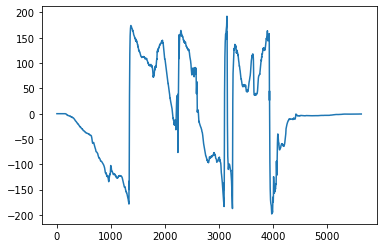

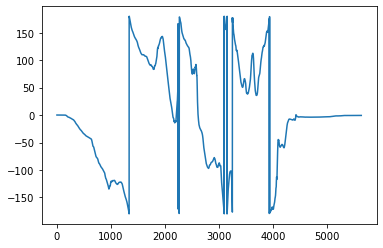

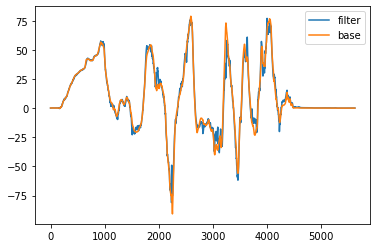

In [343]:
angle_filter = np.asarray(angle_filter)
angle_filter = np.squeeze(angle_filter)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(angle_filter[:, 0]/np.pi*180)
plt.figure()
plt.plot(angle_base[:, 0])
# plt.legend(['filter', 'base'])
plt.figure()
plt.plot(angle_filter[:, 1]/np.pi*180)

plt.plot(angle_base[:, 1])
plt.legend(['filter', 'base'])

plt.show()

## EKF based on rotation matrix integration

EKF 在进行状态更新和方差计算时，可以看到雅克比矩阵中好几项的分母为 $\cos \theta$ , 在俯仰角为正负90°时，会产生奇异性，从而使得万向节锁的特性出现，影响角度和方差的正常计算(精度降低)。
为了缓解这种现象，我们可以在欧拉角积分阶段，使用旋转矩阵的积分来代替：
$$
\frac{d\mathbf{R}}{dt} = \mathbf{R}[\boldsymbol{\omega}]_\times
$$

其中 $[\boldsymbol{\omega}]_\times$ 表示叉积矩阵，表达式为：
$$
[\boldsymbol{\omega}]_\times=\begin{bmatrix} 0 & -\omega_z & \omega_y \\ \omega_z & 0 & -\omega_x \\ -\omega_y & \omega_x & 0 \end{bmatrix}
$$

上述微分方程是有解析解的，其解的离散形式为：
$$
\begin{gathered}
\mathbf{R}(t+\Delta t)=\mathbf{R}(t)e^{[\boldsymbol{\omega}]_\times \Delta t} \\
e^{\mathbf{K}} = \sum_{n=0}^{\infty}\frac{\mathbf{K}^n}{n!}
\end{gathered}
$$

为了便于计算，上式的指数函数实际上可以写成指数映射的形式，即将一个旋转矢量映射到旋转矩阵所在的空间：
$$
e^{\theta [\boldsymbol{u}]_\times}=\mathbf{R}(\boldsymbol{u},\theta)=\mathbf{I}+ \sin \theta [\boldsymbol{u}]_\times + (1-\cos \theta)[\boldsymbol{u}]^2_\times
$$
为了让解析解能够套用上面的公式，必须对 $[\boldsymbol{\omega}]_\times \Delta t$ 做处理，因为旋转向量的 $\boldsymbol{u}$ 是单位向量，但是角速度向量 $\boldsymbol{\omega}$ 不满足这一约束：
$$
\begin{gathered}
\boldsymbol{v} = \boldsymbol{\omega}\Delta t \\
norm = Norm^2(\boldsymbol{v}) \\
e^{[\boldsymbol{\omega}]_\times \Delta t}=\mathbf{R}(\frac{\boldsymbol{v}}{norm},norm)=\mathbf{I}+ \frac{\sin (norm) [\boldsymbol{v}]_\times}{norm} + \frac{(1-\cos (norm))[\boldsymbol{v}]^2_\times}{norm^2}
\end{gathered}
$$

In [344]:
def Euler2RotateMatrix(euler_angle):
    rotate_matrix = np.zeros([3, 3], dtype=np.float64)

    rotate_matrix[0, 0] = math.cos(euler_angle[1]) * math.cos(euler_angle[2])
    rotate_matrix[0, 1] = -math.cos(euler_angle[0]) * math.sin(euler_angle[2]) + \
        math.sin(euler_angle[0]) * math.sin(euler_angle[1]) * math.cos(euler_angle[2])
    rotate_matrix[0, 2] = math.sin(euler_angle[0]) * math.sin(euler_angle[2]) + \
        math.cos(euler_angle[2]) * math.sin(euler_angle[1]) * math.cos(euler_angle[0])
    rotate_matrix[1, 0] = math.cos(euler_angle[1]) * math.sin(euler_angle[2])
    rotate_matrix[1, 1] = math.cos(euler_angle[0]) * math.cos(euler_angle[2]) + \
        math.sin(euler_angle[0]) * math.sin(euler_angle[1]) * math.sin(euler_angle[2])
    rotate_matrix[1, 2] = -math.sin(euler_angle[0]) * math.cos(euler_angle[2])	+ \
        math.sin(euler_angle[1]) * math.sin(euler_angle[2]) * math.cos(euler_angle[0])
    rotate_matrix[2, 0] = -math.sin(euler_angle[1])
    rotate_matrix[2, 1] = math.sin(euler_angle[0]) * math.cos(euler_angle[1])
    rotate_matrix[2, 2] = math.cos(euler_angle[0]) * math.cos(euler_angle[1])

    return rotate_matrix

def RotateMatrix2Euler(rotate_matrix):
    euler_angle = np.zeros([3], dtype=np.float64)

    euler_angle[0] = math.atan2(rotate_matrix[2, 1], rotate_matrix[2, 2])
    euler_angle[2] = math.atan2(rotate_matrix[1, 0], rotate_matrix[0, 0])
    euler_angle[1] = -math.atan2(rotate_matrix[2, 0],math.sqrt(rotate_matrix[1, 0]*rotate_matrix[1, 0] + \
                        rotate_matrix[0, 0]*rotate_matrix[0, 0]))

    return euler_angle

def ExpRot(v):
    normv = np.linalg.norm(v, ord=2)

    s = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]], dtype=np.float64)
    if normv == 0:
        RotM = np.identity(3)
    else:
        RotM = np.identity(3) + math.sin(normv)/normv*s + (1-math.cos(normv))/normv**2*(s@s)
    
    return RotM

In [345]:
from scipy.linalg import expm

x = np.array([[0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0],
              [0.0]], dtype=np.float64)
p_kk = np.zeros([6, 6], dtype=np.float64)

angle_filter = []
for i in range(omega_base.shape[0]):
    gx = omega_base[i, 0]/180*np.pi
    gy = omega_base[i, 1]/180*np.pi
    gz = omega_base[i, 2]/180*np.pi
    u = np.array([[gx],
                  [gy],
                  [gz]])

    phi_11 = 1 + ((gy-x[4, 0])*math.cos(x[0, 0])*math.tan(x[1, 0]) - (gz-x[5, 0])*math.sin(x[0, 0])*math.tan(x[1, 0]))*dt
    phi_12 = ((gy-x[4, 0])*math.sin(x[0, 0]) + (gz-x[5, 0])*math.cos(x[0, 0]))/(math.cos(x[1, 0])**2+1e-4)*dt
    phi_13 = 0
    phi_14 = -dt
    phi_15 = -math.sin(x[0, 0])*math.tan(x[1, 0])*dt
    phi_16 = -math.cos(x[0, 0])*math.tan(x[1, 0])*dt
    phi_21 = (-(gy-x[4, 0])*math.sin(x[0, 0]) - (gz-x[5, 0])*math.cos(x[0, 0]))*dt
    phi_22 = 1
    phi_23 = 0
    phi_24 = 0
    phi_25 = -math.cos(x[0, 0])*dt
    phi_26 = math.sin(x[0, 0])*dt
    phi_31 = ((gy-x[4, 0])*math.cos(x[0, 0])-(gz-x[5, 0])*math.sin(x[0, 0]))/(math.cos(x[1, 0])+1e-4)*dt
    phi_32 = ((gy-x[4, 0])*math.sin(x[0, 0])*math.sin(x[1, 0])+(gz-x[5, 0])*math.cos(x[0, 0])*math.sin(x[1, 0]))/(math.cos(x[1, 0])**2+1e-4)*dt
    phi_33 = 1
    phi_34 = 0
    phi_35 = -math.sin(x[0, 0])/(math.cos(x[1, 0])+1e-4)*dt
    phi_36 = -math.cos(x[0, 0])/(math.cos(x[1, 0])+1e-4)*dt
    phi_41 = phi_42 = phi_43 = phi_45 = phi_46 = 0
    phi_44 = 1
    phi_51 = phi_52 = phi_53 = phi_54 = phi_56 = 0
    phi_55 = 1
    phi_61 = phi_62 = phi_63 = phi_64 = phi_65 = 0
    phi_66 = 1
    Phi = np.array([[phi_11, phi_12, phi_13, phi_14, phi_15, phi_16],
                    [phi_21, phi_22, phi_23, phi_24, phi_25, phi_26],
                    [phi_31, phi_32, phi_33, phi_34, phi_35, phi_36],
                    [phi_41, phi_42, phi_43, phi_44, phi_45, phi_46],
                    [phi_51, phi_52, phi_53, phi_54, phi_55, phi_56],
                    [phi_61, phi_62, phi_63, phi_64, phi_65, phi_66]], dtype=np.float64)

    g_11 = dt
    g_12 = math.sin(x[0, 0])*math.tan(x[1, 0])*dt
    g_13 = math.cos(x[0, 0])*math.tan(x[1, 0])*dt
    g_21 = 0
    g_22 = math.cos(x[0 ,0])*dt
    g_23 = -math.sin(x[0, 0])*dt
    g_31 = 0
    g_32 = math.sin(x[0, 0])/(math.cos(x[1, 0]) + 1e-4)*dt
    g_33 = math.cos(x[0, 0])/(math.cos(x[1, 0]) + 1e-4)*dt
    g_41 = g_42 = g_43 = g_51 = g_52 = g_53 = g_61 = g_62 = g_63 = 0
    G = np.array([[g_11, g_12, g_13],
                  [g_21, g_22, g_23],
                  [g_31, g_32, g_33],
                  [g_41, g_42, g_43],
                  [g_51, g_52, g_53],
                  [g_61, g_62, g_63]], dtype=np.float64)
    
    euler_angle = x[0:3, 0]
    Omega_vector = np.array([gx, gy, gz], dtype=np.float64)
    # Omega = np.array([[0, -gz, gy],
    #                   [gz, 0, -gx],
    #                   [-gy, gx, 0]], dtype=np.float64)
    rotation_m = Euler2RotateMatrix(euler_angle)
    # rotation_m = rotation_m @ expm(Omega*dt)
    rotation_m = rotation_m @ ExpRot(Omega_vector*dt)
    euler_angle = RotateMatrix2Euler(rotation_m)

    x_ = np.array([[euler_angle[0]],
                   [euler_angle[1]],
                   [euler_angle[2]],
                   [x[3, 0]],
                   [x[4, 0]],
                   [x[5, 0]]])
    p = Phi @ p_kk @ Phi.T + Gamma @ Q * dt  @ Gamma.T
    K = p @ H.T @ np.linalg.inv(H @ p @ H.T + R)
    z = np.array([[math.atan2(acc_base[i, 1], acc_base[i, 2])],
                  [math.atan(-acc_base[i, 0]/math.sqrt(acc_base[i, 1]**2+acc_base[i, 2]**2))],
                  [0]], dtype=np.float64)
    x = x_ + K @ (z - H @ x_)
    p_kk = (np.identity(6) - K @ H) @ p
    angle_filter.append(x)

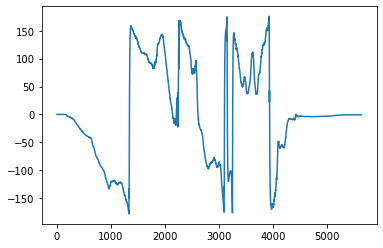

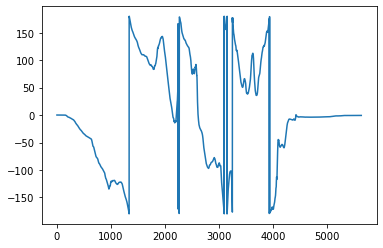

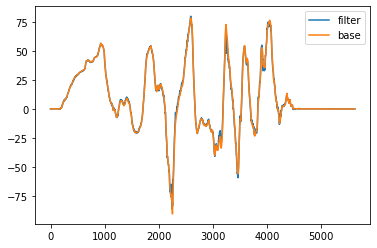

In [346]:
angle_filter = np.asarray(angle_filter)
angle_filter = np.squeeze(angle_filter)
plt.figure()
plt.plot(angle_filter[:, 0]/np.pi*180)
plt.figure()
plt.plot(angle_base[:, 0])
# plt.legend(['filter', 'base'])
plt.figure()
plt.plot(angle_filter[:, 1]/np.pi*180)

plt.plot(angle_base[:, 1])
plt.legend(['filter', 'base'])
plt.show()

## EKF based on quaternion

用四元数动力学替代欧拉角动力学具有三点好处：
* 四元数动力学方程是**线性的**，不同做线性化处理
* 四元数本身不具有奇异性，可以避免姿态表示的时候出现的万向节锁现象
* 四元数转换成旋转矩阵是**代数形式**的公式，避免了三角函数的运算，节省计算资源

但是四元数用于滤波方程仍然具有问题，根本原因是四元数用于姿态解算，其各个元素并不是独立的，需要满足单位四元数的约束，而**约束条件会使得滤波过程中的协方差矩阵理论上变成奇异的**，因为 $||\boldsymbol{q}||=1$, 那么 $cov(\boldsymbol{q},\boldsymbol{q})$ 的行列式为0. 这会给数值计算带来困难。

四元数动力学方程如下：
$$
\frac{d\boldsymbol{q}}{dt}=\frac{1}{2}\boldsymbol{q} \bigotimes \ \boldsymbol{q}_\omega
$$
其中 $\boldsymbol{q}_\omega=[0;\boldsymbol{\omega}]$

因为四元数群和旋转矩阵群基本上是同构的(除了四元数和旋转之间是2:1的对应关系)，所以和旋转矩阵一样，四元数的微分方程也有解析解：
$$
\boldsymbol{q}(t+\Delta t)=\boldsymbol{q}(t) \bigotimes e^{\frac{1}{2}\boldsymbol{q}_\omega \Delta t}
$$

同样四元数的指数运算也可以写成指数映射的形式，将旋转矢量写成实部为零的四元数 $\boldsymbol{q}_\theta$，有：
$$
e^{\frac{\boldsymbol{q}_\theta}{2}}=\boldsymbol{q}(\boldsymbol{u},\theta)=[\cos \frac{\theta}{2};\boldsymbol{u}\sin \frac{\theta}{2}]
$$

解析解套用上述公式的形式如下：
$$
\begin{gathered}
\boldsymbol{v} = \boldsymbol{q}_\omega \Delta t \\
norm = Norm^2(\boldsymbol{v}) \\ 
e^{\frac{1}{2}\boldsymbol{q}_\omega \Delta t}=\boldsymbol{q}(\frac{\boldsymbol{v}}{norm},norm)=[\cos \frac{norm}{2};\frac{\boldsymbol{v}}{norm}\sin \frac{norm}{2}]
\end{gathered}
$$

In [347]:
def Euler2Quaternion(euler_angle):
    q = np.zeros([4], dtype=np.float64)
    
    q[0] = math.cos(euler_angle[0]/2)*math.cos(euler_angle[1]/2)*math.cos(euler_angle[2]/2) + \
            math.sin(euler_angle[0]/2)*math.sin(euler_angle[1]/2)*math.sin(euler_angle[2]/2)
    q[1] = math.sin(euler_angle[0]/2)*math.cos(euler_angle[1]/2)*math.cos(euler_angle[2]/2) - \
            math.cos(euler_angle[0]/2)*math.sin(euler_angle[1]/2)*math.sin(euler_angle[2]/2)
    q[2] = math.cos(euler_angle[0]/2)*math.sin(euler_angle[1]/2)*math.cos(euler_angle[2]/2) + \
            math.sin(euler_angle[0]/2)*math.cos(euler_angle[1]/2)*math.sin(euler_angle[2]/2)
    q[3] = math.cos(euler_angle[0]/2)*math.cos(euler_angle[1]/2)*math.sin(euler_angle[2]/2) - \
            math.sin(euler_angle[0]/2)*math.sin(euler_angle[1]/2)*math.cos(euler_angle[2]/2)

    return q

def Quaternion2Euler(q):
    euler_angle = np.zeros([3], dtype=np.float64)

    euler_angle[0] = math.atan2(2.0*(q[2]*q[3]+q[0]*q[1]), q[0]**2-q[1]**2-q[2]**2+q[3]**2)
    euler_angle[1] = -math.asin(np.clip(2.0*(q[1]*q[3]-q[0]*q[2]), -1.0, 1.0))
    euler_angle[2] = math.atan2(2*(q[1]*q[2]+q[0]*q[3]), q[0]**2+q[1]**2-q[2]**2-q[3]**2)

    return euler_angle

def ExpQua(v):
    q = np.zeros([4], dtype=np.float64)

    # q*t has beed divided by 2
    v = 2 * v 
    theta = np.linalg.norm(v, ord=2)
    if theta == 0:
        q = np.array([1, 0, 0, 0])
    else:
        q[0] = math.cos(theta/2)
        q[1:] = v/theta*math.sin(theta/2) 

    return q

def MulQua(q1, q2):
    q = np.zeros([4], dtype=np.float64)

    q[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]

    return q


In [348]:
Q_angle = 0.1
R_measure = 0.12
Q = np.array([[Q_angle, 0, 0, 0],
              [0, Q_angle, 0, 0],
              [0, 0, Q_angle, 0],
              [0, 0, 0, Q_angle]])
R = np.array([[R_measure, 0, 0, 0],
              [0, R_measure, 0, 0],
              [0, 0, R_measure, 0],
              [0, 0, 0, R_measure]])
angle = np.array([[0.0],
                  [0.0],
                  [0.0]], dtype=np.float64)
p_kk = np.zeros([4, 4], dtype=np.float64)
q_est = Euler2Quaternion(angle)

angle_filter = []
for i in range(omega_base.shape[0]):
    gx = omega_base[i, 0]/180*np.pi
    gy = omega_base[i, 1]/180*np.pi
    gz = omega_base[i, 2]/180*np.pi
    u = np.array([gx, gy, gz], dtype = np.float64)
    dq = ExpQua(u*0.5*dt)
    q_est = MulQua(q_est, dq)

    Phi = np.array([[dq[0], -dq[1], -dq[2], -dq[3]],
                    [dq[1], dq[0], dq[3], -dq[2]],
                    [dq[2], -dq[3], dq[0], dq[1]],
                    [dq[3], dq[2], -dq[1], dq[0]]], dtype=np.float64)
    G = np.array([[q_est[0], -q_est[1], -q_est[2], -q_est[3]],
                  [q_est[1], q_est[0], -q_est[3], q_est[2]],
                  [q_est[2], q_est[3], q_est[0], -q_est[1]],
                  [q_est[3], -q_est[2], q_est[1], q_est[0]]], dtype=np.float64)
    
    p = Phi @ p_kk @ Phi.T + G @ Q * dt  @ G.T
    K = p @ np.linalg.inv(p + R)
    angle_est = Quaternion2Euler(q_est)
    z = np.array([[math.atan2(acc_base[i, 1], acc_base[i, 2])],
                  [math.atan(-acc_base[i, 0]/math.sqrt(acc_base[i, 1]**2+acc_base[i, 2]**2))],
                  [angle_est[2]]], dtype=np.float64)
    qmea = Euler2Quaternion(z)
    dq = qmea - q_est
    q_est = q_est + K @ dq
    q_est = q_est / np.linalg.norm(q_est, ord=2)
    p_kk = (np.identity(4) - K) @ p
    angle_filter.append(Quaternion2Euler(q_est))

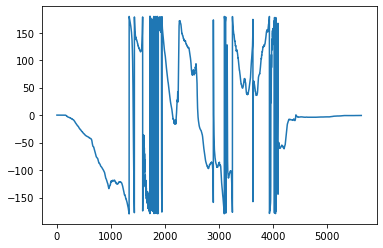

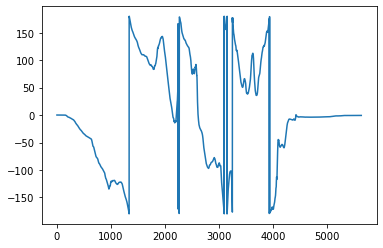

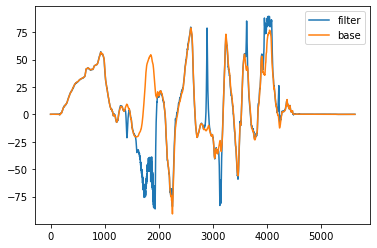

In [349]:
angle_filter = np.asarray(angle_filter)
plt.figure()
plt.plot(angle_filter[:, 0]/np.pi*180)
plt.figure()
plt.plot(angle_base[:, 0])
# plt.legend(['filter', 'base'])
plt.figure()
plt.plot(angle_filter[:, 1]/np.pi*180)
plt.plot(angle_base[:, 1])
plt.legend(['filter', 'base'])

plt.show()

## MEKF

上文提到了即便用四元数来进行姿态解算，仍然会遇到协方差矩阵奇异性的问题。MEKF为了解决这个问题，提出了姿态误差这个概念。其核心思想如下：
$$
\boldsymbol{q}(t)=\boldsymbol{q}_{ref} \bigotimes \delta \boldsymbol{q}(\boldsymbol{a}(t))
$$
对于姿态真值使用两个变量去描述:一个是不受约束的由三个参数组成的姿态误差 $\boldsymbol{a}(t)$；一个是受约束的四元数来描述对姿态的估计。$\boldsymbol{a}(t)$的协方差矩阵可以代替原来的协方差矩阵描述不确定度，因为这个参数不受约束，所以其协方差矩阵不会受到奇异性的影响。

In [353]:
def InvQua(q):
    q_inv = np.zeros([4], dtype=np.float64)

    q_inv[0] = q[0]
    q_inv[1:4] = -q[1:4]

    return q_inv

# def ExpRot(v):
#     normv = np.linalg.norm(v, ord=2)

#     s = np.array([[0, -v[2], v[1]],
#                   [v[2], 0, -v[0]],
#                   [-v[1], v[0], 0]], dtype=np.float64)
#     if normv == 0:
#         RotM = np.identity(3)
#     else:
#         RotM = np.identity(3) + math.sin(normv)/normv*s + (1-math.cos(normv))/normv**2*(s@s)
    
#     return RotM

def WraptoPi(x):
    xwrap = x % (2*np.pi)
    if abs(xwrap) > np.pi:
        xwrap = xwrap - 2*np.pi*np.sign(xwrap)

    return xwrap

def LogQua(q):
    norm_qv = np.linalg.norm(q[1:], ord=2)
    # if abs(q[0]-1) <= 1e-4:
    if q[0] == 1:
        u = np.array([[1],
                      [0],
                      [0]])
        theta = 0
    else:
        u = q[1:]/norm_qv
        theta = WraptoPi(math.atan2(norm_qv, q[0])*2)
    v = u*theta

    return v

In [354]:
Q_angle = 0.01
R_measure = 0.12
Q = np.array([[Q_angle, 0, 0],
              [0, Q_angle, 0],
              [0, 0, Q_angle]])
R = np.array([[R_measure, 0, 0],
              [0, R_measure, 0],
              [0, 0, R_measure]])
angle = np.array([[0.0],
                  [0.0],
                  [0.0]], dtype=np.float64)
p_kk = np.zeros([3, 3], dtype=np.float64)
q_est = Euler2Quaternion(angle)

angle_filter = []
for i in range(omega_base.shape[0]):
    gx = omega_base[i, 0]/180*np.pi
    gy = omega_base[i, 1]/180*np.pi
    gz = omega_base[i, 2]/180*np.pi
    u = np.array([gx, gy, gz], dtype = np.float64)
    dq = ExpQua(u*0.5*dt)
    q_est = MulQua(q_est, dq)

    Phi = ExpRot(u*dt)
    
    p = Phi @ p_kk @ Phi.T + Q * dt
    K = p @ np.linalg.inv(p + R)
    angle_est = Quaternion2Euler(q_est)
    z = np.array([[math.atan2(acc_base[i, 1], acc_base[i, 2])],
                  [math.atan(-acc_base[i, 0]/math.sqrt(acc_base[i, 1]**2+acc_base[i, 2]**2))],
                  [angle_est[2]]], dtype=np.float64)
    qmea = Euler2Quaternion(z)
    dv = K @ LogQua(MulQua(InvQua(q_est), qmea))
    q_est = MulQua(q_est, ExpQua(dv))
    p_kk = (np.identity(3) - K) @ p
    angle_filter.append(Quaternion2Euler(q_est))

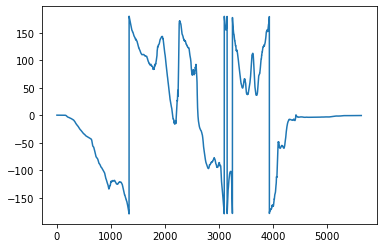

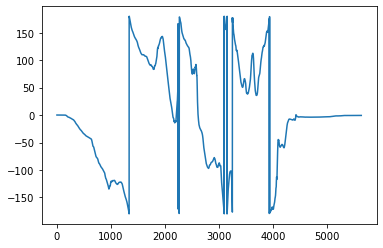

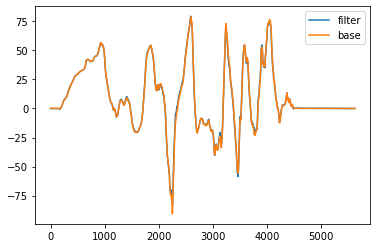

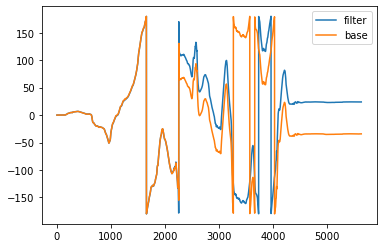

In [355]:
angle_filter = np.asarray(angle_filter)
plt.figure()
plt.plot(angle_filter[:, 0]/np.pi*180)
plt.figure()
plt.plot(angle_base[:, 0])
# plt.legend(['filter', 'base'])
plt.figure()
plt.plot(angle_filter[:, 1]/np.pi*180)
# plt.figure()
plt.plot(angle_base[:, 1])
plt.legend(['filter', 'base'])

plt.figure()
plt.plot(angle_filter[:, 2]/np.pi*180)
plt.plot(angle_base[:, 2])
plt.legend(['filter', 'base'])
plt.show()